In [ ]:
pip install catboost

In [ ]:
import math, time, random, datetime

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import missingno
import seaborn as sns
plt.style.use('seaborn-whitegrid')


from sklearn.preprocessing import OneHotEncoder, LabelEncoder, label_binarize

import catboost
from sklearn.model_selection import train_test_split
from sklearn import model_selection, tree, preprocessing, metrics, linear_model
from sklearn.linear_model import LinearRegression, LogisticRegression, SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import LinearSVC
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from catboost import CatBoostClassifier, Pool, cv

import warnings
warnings.filterwarnings('ignore')

In [ ]:
train = pd.read_csv('/content/train.csv')
test = pd.read_csv('/content/test.csv')
gender_submission = pd.read_csv('/content/gender_submission.csv')

In [ ]:
train.head(5)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [ ]:
test.head(5)

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [ ]:
gender_submission.head(5)

,PassengerId,Survived
0,892,0
1,893,1
2,894,0
3,895,0
4,896,1


In [ ]:
train.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


**MISSING VALUES**

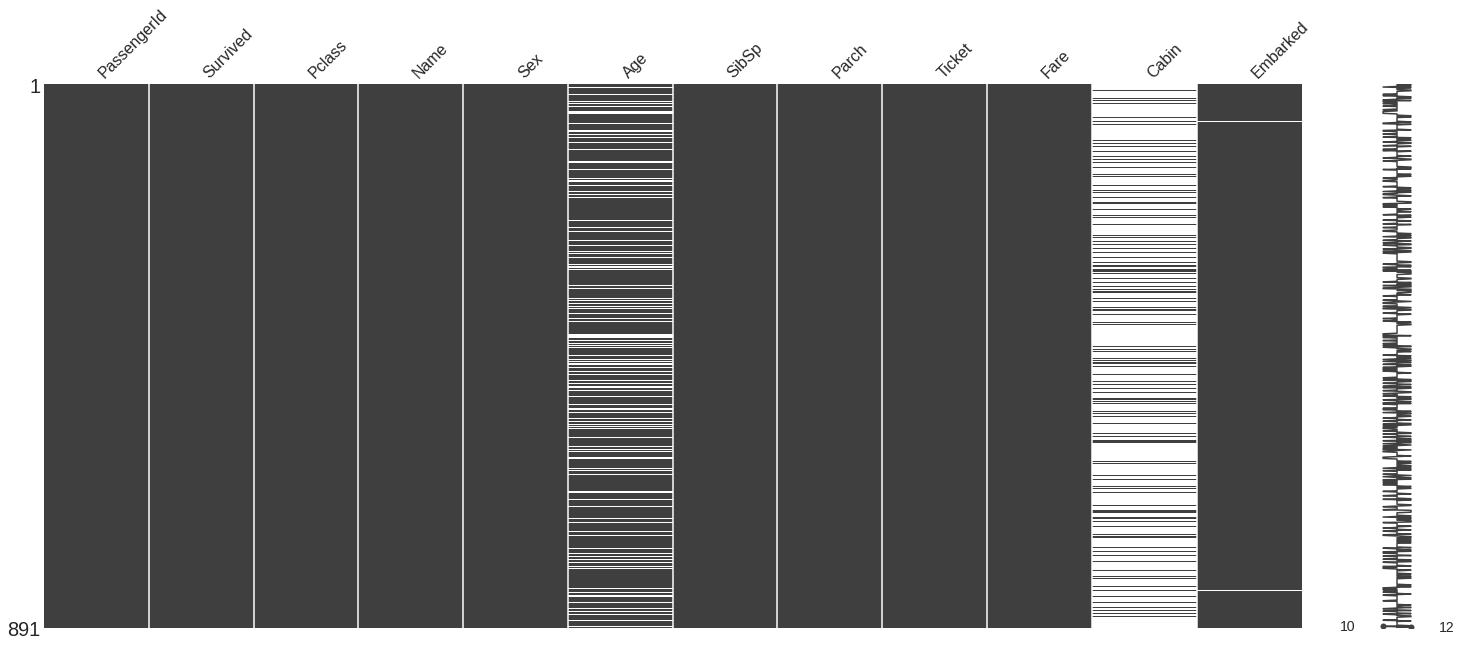

In [ ]:
missingno.matrix(train, figsize = (25,10))

In [ ]:
train.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

In [ ]:
train.dtypes

PassengerId      int64
Survived         int64
Pclass           int64
Name            object
Sex             object
Age            float64
SibSp            int64
Parch            int64
Ticket          object
Fare           float64
Cabin           object
Embarked        object
dtype: object

In [ ]:
df_bin = pd.DataFrame() 
df_con = pd.DataFrame() 

**Target : Survived**

In [ ]:
train['Survived'].value_counts()

0    549
1    342
Name: Survived, dtype: int64

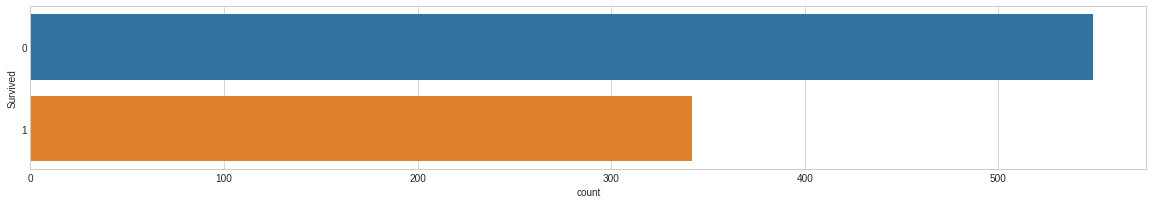

In [ ]:
fig = plt.figure(figsize=(20,3))
sns.countplot(y='Survived', data=train);

In [ ]:
df_bin['Survived'] = train['Survived']
df_con['Survived'] = train['Survived']

**Feature : Pclass**

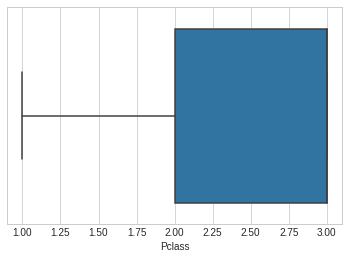

In [ ]:
sns.boxplot(train.Pclass)

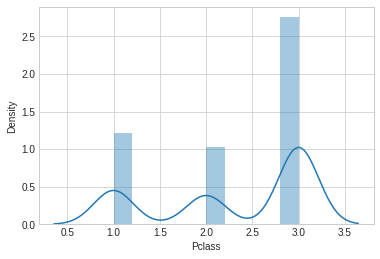

In [ ]:
sns.distplot(train.Pclass)

In [ ]:
train['Pclass'].value_counts()

3    491
1    216
2    184
Name: Pclass, dtype: int64

In [ ]:
train['Pclass'].isnull().sum()

0

In [ ]:
df_bin['Pclass'] = train['Pclass']
df_con['Pclass'] = train['Pclass']

**Feature : Sex**

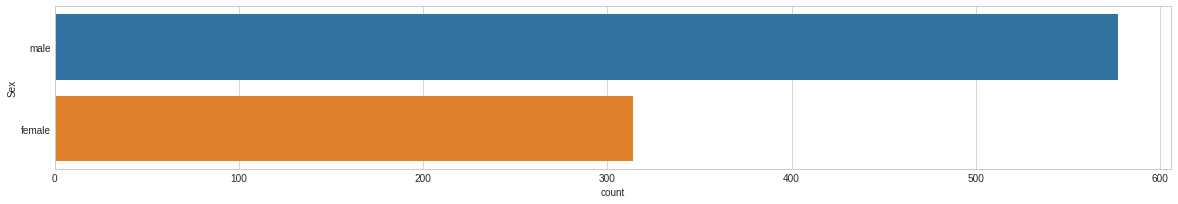

In [ ]:
plt.figure(figsize=(20, 3))
sns.countplot(y="Sex", data=train);

In [ ]:
df_bin['Sex'] = train['Sex']
df_bin['Sex'] = np.where(df_bin['Sex'] == 'female', 1, 0) 
df_con['Sex'] = train['Sex']

In [ ]:
df_bin.head()

,Survived,Pclass,Sex
0,0,3,0
1,1,1,1
2,1,3,1
3,1,1,1
4,0,3,0


In [ ]:
df_con.head()

,Survived,Pclass,Sex
0,0,3,male
1,1,1,female
2,1,3,female
3,1,1,female
4,0,3,male


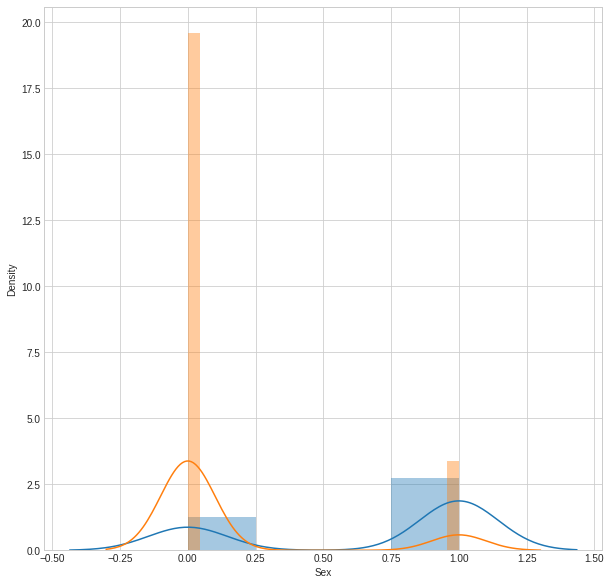

In [ ]:
fig = plt.figure(figsize=(10, 10))
sns.distplot(df_bin.loc[df_bin['Survived'] == 1]['Sex'], kde_kws={'label': 'Survived'});
sns.distplot(df_bin.loc[df_bin['Survived'] == 0]['Sex'], kde_kws={'label': 'Did not survive'});

**FEATURE : Embarked**

In [ ]:
print(train['Embarked'].isnull().sum())
print(test['Embarked'].isnull().sum())

2
0


In [ ]:
train.Embarked.value_counts()

S    644
C    168
Q     77
Name: Embarked, dtype: int64

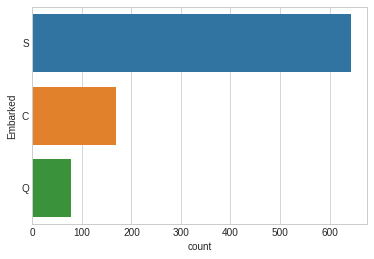

In [ ]:
sns.countplot(y='Embarked', data=train);

In [ ]:
df_bin['Embarked'] = train['Embarked']
df_con['Embarked'] = train['Embarked']

In [ ]:
print(len(df_con))
df_con = df_con.dropna(subset=['Embarked'])
df_bin = df_bin.dropna(subset=['Embarked'])
print(len(df_con))

891
889


**FEATURE : Name and Age**

TRAIN

In [ ]:
train['Title']=train['Name'].apply(lambda x: x.split(',')[1].split('.')[0].strip())

In [ ]:
train['Title'].value_counts()

Mr              517
Miss            182
Mrs             125
Master           40
Dr                7
Rev               6
Mlle              2
Col               2
Major             2
Capt              1
Lady              1
Sir               1
Mme               1
Don               1
the Countess      1
Jonkheer          1
Ms                1
Name: Title, dtype: int64

In [ ]:
pd.crosstab(train.Title,train.Sex)

Sex,female,male
Title,,
Capt,0,1
Col,0,2
Don,0,1
Dr,1,6
Jonkheer,0,1
Lady,1,0
Major,0,2
Master,0,40
Miss,182,0


In [ ]:
train[(train.Title=='Dr')&(train.Sex=='female')]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title
796,797,1,1,"Leader, Dr. Alice (Farnham)",female,49.0,0,0,17465,25.9292,D17,S,Dr


In [ ]:
colm={'Capt':'Rareman', 'Col':'Rareman','Don':'Rareman','Dona':'Rarewoman',
    'Dr':'Rareman','Jonkheer':'Rareman','Lady':'Rarewoman','Major':'Rareman',
    'Master':'Master','Miss':'Miss','Mlle':'Rarewoman','Mme':'Rarewoman',
    'Mr':'Mr','Mrs':'Mrs','Ms':'Rarewoman','Rev':'Mr','Sir':'Rareman',
    'the Countess':'Rarewoman'}

In [ ]:
train.Title=train.Title.map(colm)

In [ ]:
train.loc[train.PassengerId==797,'Title']='Rarewoman'

In [ ]:
train['Title'].value_counts()

Mr           523
Miss         182
Mrs          125
Master        40
Rareman       14
Rarewoman      7
Name: Title, dtype: int64

In [ ]:
train[train.Title=='Master']['Sex'].value_counts()

male    40
Name: Sex, dtype: int64

In [ ]:
train.Age.fillna(999,inplace=True)

In [ ]:
def girl(aa):
    if (aa.Age!=999)&(aa.Title=='Miss')&(aa.Age<=14):
        return 'Girl'
    elif (aa.Age==999)&(aa.Title=='Miss')&(aa.Parch!=0):
        return 'Girl'
    else:
        return aa.Title

In [ ]:
train['Title']=train.apply(girl,axis=1)

In [ ]:
train.Title.value_counts()

Mr           523
Miss         136
Mrs          125
Girl          46
Master        40
Rareman       14
Rarewoman      7
Name: Title, dtype: int64

In [ ]:
train[train.Age==999]['Age'].value_counts()

999.0    177
Name: Age, dtype: int64

In [ ]:
Tit=['Mr','Miss','Mrs','Master','Girl','Rareman','Rarewoman']
for i in Tit:
    train.loc[(train.Age==999)&(train.Title==i),'Age']=train.loc[train.Title==i,'Age'].median()

In [ ]:
train.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age              0
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
Title            0
dtype: int64

In [ ]:
test.isnull().sum()

PassengerId      0
Pclass           0
Name             0
Sex              0
Age             86
SibSp            0
Parch            0
Ticket           0
Fare             1
Cabin          327
Embarked         0
dtype: int64

TEST

In [ ]:
test['Title']=test['Name'].apply(lambda x: x.split(',')[1].split('.')[0].strip())

In [ ]:
test['Title'].value_counts()

Mr        240
Miss       78
Mrs        72
Master     21
Rev         2
Col         2
Dr          1
Dona        1
Ms          1
Name: Title, dtype: int64

In [ ]:
pd.crosstab(test.Title,test.Sex)

Sex,female,male
Title,,
Col,0,2
Dona,1,0
Dr,0,1
Master,0,21
Miss,78,0
Mr,0,240
Mrs,72,0
Ms,1,0
Rev,0,2


In [ ]:
test['Title'].value_counts()

Mr        240
Miss       78
Mrs        72
Master     21
Rev         2
Col         2
Dr          1
Dona        1
Ms          1
Name: Title, dtype: int64

In [ ]:
test[(test.Title=='Dr')&(test.Sex=='female')]

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title


In [ ]:
colm={'Capt':'Rareman', 'Col':'Rareman','Don':'Rareman','Dona':'Rarewoman',
    'Dr':'Rareman','Jonkheer':'Rareman','Lady':'Rarewoman','Major':'Rareman',
    'Master':'Master','Miss':'Miss','Mlle':'Rarewoman','Mme':'Rarewoman',
    'Mr':'Mr','Mrs':'Mrs','Ms':'Rarewoman','Rev':'Mr','Sir':'Rareman',
    'the Countess':'Rarewoman'}

In [ ]:
test.Title=test.Title.map(colm)

In [ ]:
test.loc[test.PassengerId==797,'Title']='Rarewoman'

In [ ]:
test['Title'].value_counts()

Mr           242
Miss          78
Mrs           72
Master        21
Rareman        3
Rarewoman      2
Name: Title, dtype: int64

In [ ]:
test.Age.fillna(999,inplace=True)

In [ ]:
Tit=['Mr','Miss','Mrs','Master','Girl','Rareman','Rarewoman']
for i in Tit:
    test.loc[(test.Age==999)&(test.Title==i),'Age']=test.loc[test.Title==i,'Age'].median()

In [ ]:
test.isnull().sum()

PassengerId      0
Pclass           0
Name             0
Sex              0
Age              0
SibSp            0
Parch            0
Ticket           0
Fare             1
Cabin          327
Embarked         0
Title            0
dtype: int64

In [ ]:
train['Age'].isnull().sum()

0

In [ ]:
test['Age'].isnull().sum()

0

In [ ]:
df_bin['Age'] = pd.cut(train['Age'], 10)
df_con['Age'] = train['Age']

In [ ]:
def plot_count_dist(data, bin_df, label_column, target_column, figsize=(20, 5), use_bin_df=False):
    
    if use_bin_df: 
        fig = plt.figure(figsize=figsize)
        plt.subplot(1, 2, 1)
        sns.countplot(y=target_column, data=bin_df);
        plt.subplot(1, 2, 2)
        sns.distplot(data.loc[data[label_column] == 1][target_column], 
                     kde_kws={"label": "Survived"});
        sns.distplot(data.loc[data[label_column] == 0][target_column], 
                     kde_kws={"label": "Did not survive"});
    else:
        fig = plt.figure(figsize=figsize)
        plt.subplot(1, 2, 1)
        sns.countplot(y=target_column, data=data);
        plt.subplot(1, 2, 2)
        sns.distplot(data.loc[data[label_column] == 1][target_column], 
                     kde_kws={"label": "Survived"});
        sns.distplot(data.loc[data[label_column] == 0][target_column], 
                     kde_kws={"label": "Did not survive"});

**Feature : SibSp**

In [ ]:
train.SibSp.isnull().sum()

0

In [ ]:
train.SibSp.value_counts()

0    608
1    209
2     28
4     18
3     16
8      7
5      5
Name: SibSp, dtype: int64

In [ ]:
df_bin['SibSp'] = train['SibSp']
df_con['SibSp'] = train['SibSp']

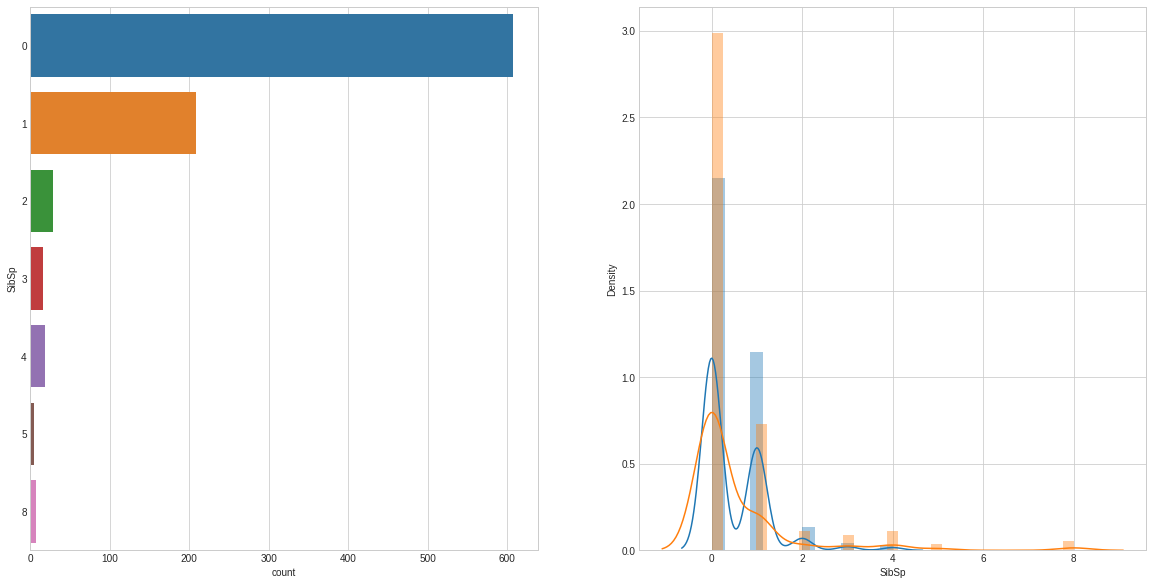

In [ ]:
plot_count_dist(train, bin_df=df_bin, label_column='Survived', target_column='SibSp', figsize=(20, 10))

**Feature : Parch**

In [ ]:
train.Parch.isnull().sum()

0

In [ ]:
train.Parch.value_counts()

0    678
1    118
2     80
5      5
3      5
4      4
6      1
Name: Parch, dtype: int64

In [ ]:
df_bin['Parch'] = train['Parch']
df_con['Parch'] = train['Parch']

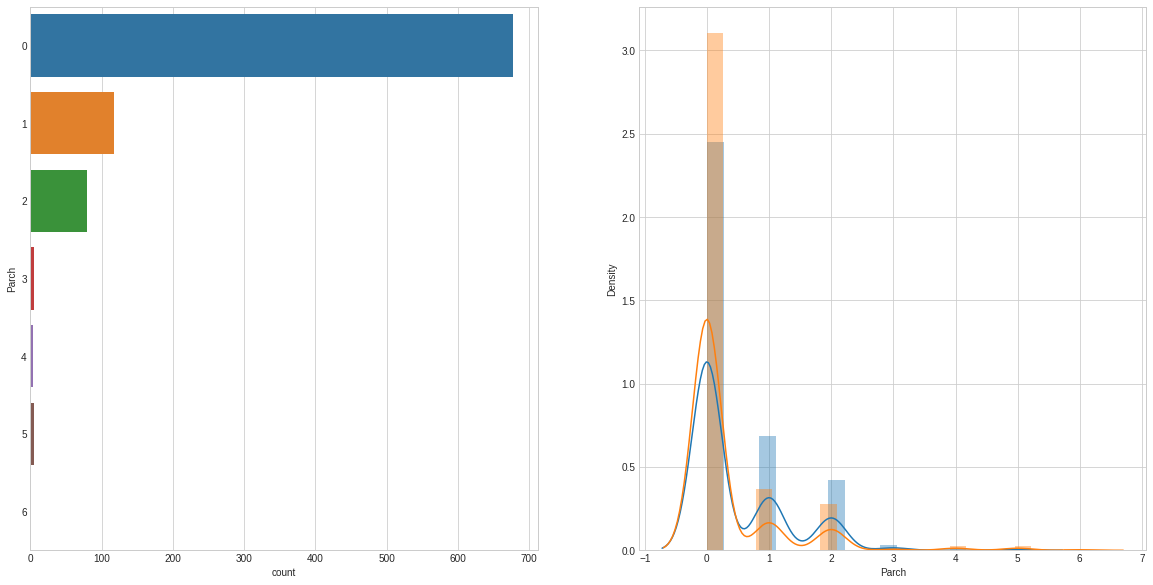

In [ ]:
plot_count_dist(train, bin_df=df_bin, label_column='Survived', target_column='Parch', figsize=(20, 10))

In [ ]:
df_bin.head()

,Survived,Pclass,Sex,Embarked,Age,SibSp,Parch
0,0,3,0,S,"(16.336, 24.294]",1,0
1,1,1,1,C,"(32.252, 40.21]",1,0
2,1,3,1,S,"(24.294, 32.252]",0,0
3,1,1,1,S,"(32.252, 40.21]",1,0
4,0,3,0,S,"(32.252, 40.21]",0,0


In [ ]:
df_con.head()

,Survived,Pclass,Sex,Embarked,Age,SibSp,Parch
0,0,3,male,S,22.0,1,0
1,1,1,female,C,38.0,1,0
2,1,3,female,S,26.0,0,0
3,1,1,female,S,35.0,1,0
4,0,3,male,S,35.0,0,0


**Feature : Ticket**

In [ ]:
train.Ticket.isnull().sum()

0

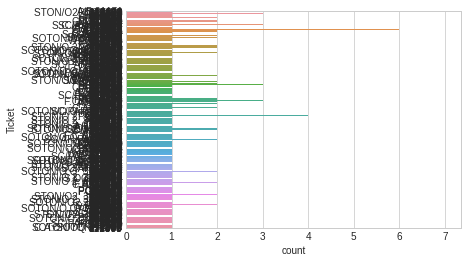

In [ ]:
sns.countplot(y="Ticket", data=train);

In [ ]:
train.Ticket.value_counts()

1601         7
347082       7
CA. 2343     7
CA 2144      6
347088       6
            ..
2680         1
334912       1
349251       1
A/5. 2151    1
PC 17609     1
Name: Ticket, Length: 681, dtype: int64

In [ ]:
print("{} unique Ticket".format(len(train.Ticket.unique())))

681 unique Ticket


**Feature : Fare**

In [ ]:
train.Fare.isnull().sum()

0

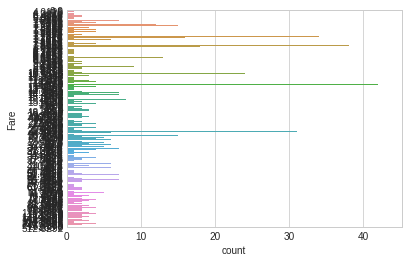

In [ ]:
sns.countplot(y="Fare", data=train);

In [ ]:
print("{} unique Fare".format(len(train.Fare.unique())))

248 unique Fare


In [ ]:
df_con['Fare'] = train['Fare'] 
df_bin['Fare'] = pd.cut(train['Fare'], bins=5)

In [ ]:
df_bin.Fare.value_counts()

(-0.512, 102.466]     836
(102.466, 204.932]     33
(204.932, 307.398]     17
(409.863, 512.329]      3
(307.398, 409.863]      0
Name: Fare, dtype: int64

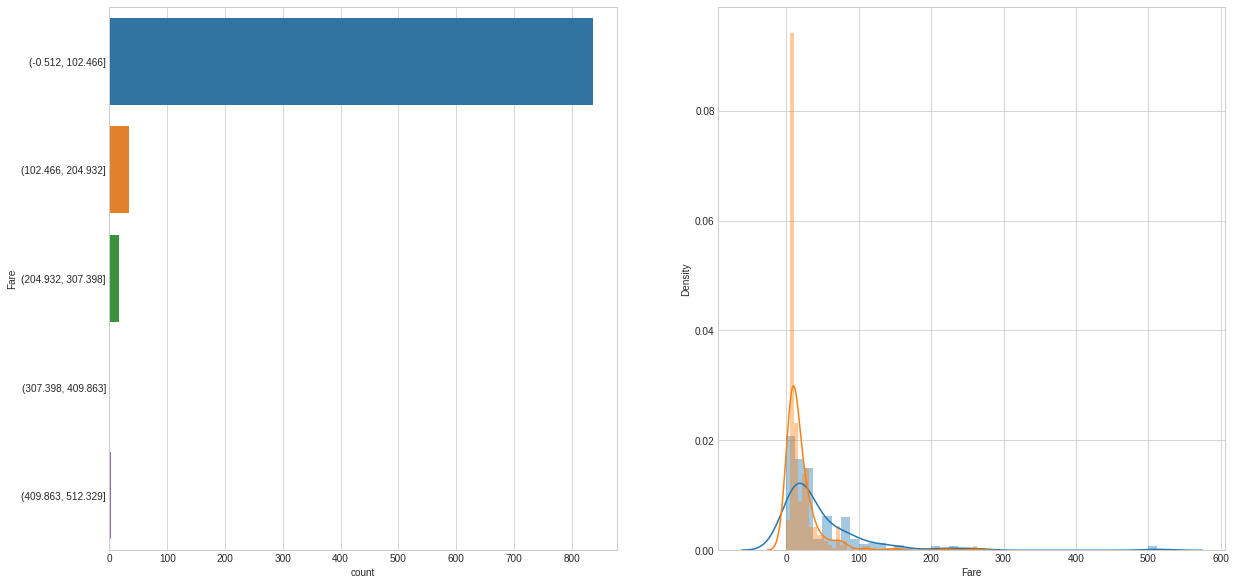

In [ ]:
plot_count_dist(data=train,bin_df=df_bin,label_column='Survived', target_column='Fare', figsize=(20,10), use_bin_df=True)

**Feature : Cabin**

In [ ]:
train.Cabin.isnull().sum()

687

In [ ]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,Mr
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,Mrs
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,Miss
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,Mrs
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,Mr


In [ ]:
df_bin.head()

,Survived,Pclass,Sex,Embarked,Age,SibSp,Parch,Fare
0,0,3,0,S,"(16.336, 24.294]",1,0,"(-0.512, 102.466]"
1,1,1,1,C,"(32.252, 40.21]",1,0,"(-0.512, 102.466]"
2,1,3,1,S,"(24.294, 32.252]",0,0,"(-0.512, 102.466]"
3,1,1,1,S,"(32.252, 40.21]",1,0,"(-0.512, 102.466]"
4,0,3,0,S,"(32.252, 40.21]",0,0,"(-0.512, 102.466]"


In [ ]:
df_con.head()

,Survived,Pclass,Sex,Embarked,Age,SibSp,Parch,Fare
0,0,3,male,S,22.0,1,0,7.2500
1,1,1,female,C,38.0,1,0,71.2833
2,1,3,female,S,26.0,0,0,7.9250
3,1,1,female,S,35.0,1,0,53.1000
4,0,3,male,S,35.0,0,0,8.0500


In [ ]:
one_hot_cols = df_bin.columns.tolist()
one_hot_cols.remove('Survived')
df_bin_enc = pd.get_dummies(df_bin, columns=one_hot_cols)

df_bin_enc.head()

,Survived,Pclass_1,Pclass_2,Pclass_3,Sex_0,Sex_1,Embarked_C,Embarked_Q,Embarked_S,"Age_(0.34, 8.378]","Age_(8.378, 16.336]","Age_(16.336, 24.294]","Age_(24.294, 32.252]","Age_(32.252, 40.21]","Age_(40.21, 48.168]","Age_(48.168, 56.126]","Age_(56.126, 64.084]","Age_(64.084, 72.042]","Age_(72.042, 80.0]",SibSp_0,SibSp_1,SibSp_2,SibSp_3,SibSp_4,SibSp_5,SibSp_8,Parch_0,Parch_1,Parch_2,Parch_3,Parch_4,Parch_5,Parch_6,"Fare_(-0.512, 102.466]","Fare_(102.466, 204.932]","Fare_(204.932, 307.398]","Fare_(307.398, 409.863]","Fare_(409.863, 512.329]"
0,0,0,0,1,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0
1,1,1,0,0,0,1,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0
2,1,0,0,1,0,1,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0
3,1,1,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0
4,0,0,0,1,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0


In [ ]:
df_con.head()

,Survived,Pclass,Sex,Embarked,Age,SibSp,Parch,Fare
0,0,3,male,S,22.0,1,0,7.2500
1,1,1,female,C,38.0,1,0,71.2833
2,1,3,female,S,26.0,0,0,7.9250
3,1,1,female,S,35.0,1,0,53.1000
4,0,3,male,S,35.0,0,0,8.0500


In [ ]:
df_embarked_one_hot = pd.get_dummies(df_con['Embarked'], 
                                     prefix='embarked')

df_sex_one_hot = pd.get_dummies(df_con['Sex'], 
                                prefix='sex')

df_plcass_one_hot = pd.get_dummies(df_con['Pclass'], 
                                   prefix='pclass')

In [ ]:
df_con_enc = pd.concat([df_con, 
                        df_embarked_one_hot, 
                        df_sex_one_hot, 
                        df_plcass_one_hot], axis=1)

df_con_enc = df_con_enc.drop(['Pclass', 'Sex', 'Embarked'], axis=1)

In [ ]:
df_con_enc.head()

,Survived,Age,SibSp,Parch,Fare,embarked_C,embarked_Q,embarked_S,sex_female,sex_male,pclass_1,pclass_2,pclass_3
0,0,22.0,1,0,7.2500,0,0,1,0,1,0,0,1
1,1,38.0,1,0,71.2833,1,0,0,1,0,1,0,0
2,1,26.0,0,0,7.9250,0,0,1,1,0,0,0,1
3,1,35.0,1,0,53.1000,0,0,1,1,0,1,0,0
4,0,35.0,0,0,8.0500,0,0,1,0,1,0,0,1


**SELECTING DATA**

In [ ]:
selected_df = df_con_enc

In [ ]:

selected_df.head()

,Survived,Age,SibSp,Parch,Fare,embarked_C,embarked_Q,embarked_S,sex_female,sex_male,pclass_1,pclass_2,pclass_3
0,0,22.0,1,0,7.2500,0,0,1,0,1,0,0,1
1,1,38.0,1,0,71.2833,1,0,0,1,0,1,0,0
2,1,26.0,0,0,7.9250,0,0,1,1,0,0,0,1
3,1,35.0,1,0,53.1000,0,0,1,1,0,1,0,0
4,0,35.0,0,0,8.0500,0,0,1,0,1,0,0,1


In [ ]:
X_train = selected_df.drop('Survived', axis=1) 
y_train = selected_df.Survived 

In [ ]:
X_train.shape

(889, 12)

In [ ]:
y_train.shape

(889,)

**Function for algorithms**

In [ ]:
def fit_ml_algo(algo, X_train, y_train, cv):
    
    # One Pass
    model = algo.fit(X_train, y_train)
    acc = round(model.score(X_train, y_train) * 100, 2)
    
    # Cross Validation 
    train_pred = model_selection.cross_val_predict(algo, 
                                                  X_train, 
                                                  y_train, 
                                                  cv=cv, 
                                                  n_jobs = -1)
    # Cross-validation accuracy metric
    acc_cv = round(metrics.accuracy_score(y_train, train_pred) * 100, 2)
    
    return train_pred, acc, acc_cv

**Logistic Regression**

In [ ]:
#start_time = time.time()
train_pred_log, acc_log, acc_cv_log = fit_ml_algo(LogisticRegression(),X_train,y_train,10)
#log_time = (time.time() - start_time)
print("Accuracy: %s" % acc_log)
print("Accuracy CV 10-Fold: %s" % acc_cv_log)
#print("Running Time: %s" % datetime.timedelta(seconds=log_time))

Accuracy: 80.31
Accuracy CV 10-Fold: 79.64


**K-Nearest Neighbours**

In [ ]:
train_pred_knn, acc_knn, acc_cv_knn = fit_ml_algo(KNeighborsClassifier(),X_train,y_train,10)

print("Accuracy: %s" % acc_knn)
print("Accuracy CV 10-Fold: %s" % acc_cv_knn)

Accuracy: 81.55
Accuracy CV 10-Fold: 71.54


**Linear Support Vector Machines (SVC)**

In [ ]:
train_pred_svc, acc_linear_svc, acc_cv_linear_svc = fit_ml_algo(LinearSVC(),X_train, y_train,10)

print("Accuracy: %s" % acc_linear_svc)
print("Accuracy CV 10-Fold: %s" % acc_cv_linear_svc)

Accuracy: 77.84
Accuracy CV 10-Fold: 69.18


**Descision tree**

In [ ]:
train_pred_dt, acc_dt, acc_cv_dt = fit_ml_algo(DecisionTreeClassifier(),X_train,y_train,10)

print("Accuracy: %s" % acc_dt)
print("Accuracy CV 10-Fold: %s" % acc_cv_dt)

Accuracy: 98.2
Accuracy CV 10-Fold: 77.95


**Naive Bayes**

In [ ]:

train_pred_gaussian, acc_gaussian, acc_cv_gaussian = fit_ml_algo(GaussianNB(),X_train, y_train,10)

print("Accuracy: %s" % acc_gaussian)
print("Accuracy CV 10-Fold: %s" % acc_cv_gaussian)

Accuracy: 78.85
Accuracy CV 10-Fold: 78.4


**Gradient desent**

In [ ]:
train_pred_sgd, acc_sgd, acc_cv_sgd = fit_ml_algo(SGDClassifier(),  X_train, y_train,10)
print("Accuracy: %s" % acc_sgd)
print("Accuracy CV 10-Fold: %s" % acc_cv_sgd)

Accuracy: 63.78
Accuracy CV 10-Fold: 74.02


**Gradient boost**

In [ ]:
train_pred_gbt, acc_gbt, acc_cv_gbt = fit_ml_algo(GradientBoostingClassifier(), X_train, y_train,10)

print("Accuracy: %s" % acc_gbt)
print("Accuracy CV 10-Fold: %s" % acc_cv_gbt)

Accuracy: 89.65
Accuracy CV 10-Fold: 83.01


**Cat boost**

In [ ]:
X_train.head()

,Age,SibSp,Parch,Fare,embarked_C,embarked_Q,embarked_S,sex_female,sex_male,pclass_1,pclass_2,pclass_3
0,22.0,1,0,7.2500,0,0,1,0,1,0,0,1
1,38.0,1,0,71.2833,1,0,0,1,0,1,0,0
2,26.0,0,0,7.9250,0,0,1,1,0,0,0,1
3,35.0,1,0,53.1000,0,0,1,1,0,1,0,0
4,35.0,0,0,8.0500,0,0,1,0,1,0,0,1


In [ ]:
y_train.head()

0    0
1    1
2    1
3    1
4    0
Name: Survived, dtype: int64

In [ ]:
cat_features = np.where(X_train.dtypes != np.float)[0]
cat_features

array([ 1,  2,  4,  5,  6,  7,  8,  9, 10, 11])

In [ ]:
train_pool = Pool(X_train,y_train,cat_features)

In [ ]:
y_train.head()

0    0
1    1
2    1
3    1
4    0
Name: Survived, dtype: int64

In [ ]:
catboost_model = CatBoostClassifier(iterations=1000,
                                    custom_loss=['Accuracy'],
                                    loss_function='Logloss')

# Fit CatBoost model
catboost_model.fit(train_pool,
                   plot=True)

# CatBoost accuracy
acc_catboost = round(catboost_model.score(X_train, y_train) * 100, 2)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Learning rate set to 0.009797
0:	learn: 0.6864479	total: 5.13ms	remaining: 5.13s
1:	learn: 0.6793302	total: 10.5ms	remaining: 5.22s
2:	learn: 0.6737958	total: 13.1ms	remaining: 4.35s
3:	learn: 0.6677669	total: 16.2ms	remaining: 4.03s
4:	learn: 0.6615128	total: 19.3ms	remaining: 3.83s
5:	learn: 0.6549054	total: 22.2ms	remaining: 3.68s
6:	learn: 0.6508701	total: 25.2ms	remaining: 3.57s
7:	learn: 0.6453893	total: 28.1ms	remaining: 3.49s
8:	learn: 0.6403987	total: 31.1ms	remaining: 3.43s
9:	learn: 0.6368270	total: 33ms	remaining: 3.26s
10:	learn: 0.6315595	total: 35.8ms	remaining: 3.22s
11:	learn: 0.6264906	total: 38.7ms	remaining: 3.19s
12:	learn: 0.6216436	total: 41.5ms	remaining: 3.15s
13:	learn: 0.6177301	total: 44.4ms	remaining: 3.13s
14:	learn: 0.6123952	total: 49.2ms	remaining: 3.23s
15:	learn: 0.6084209	total: 52.7ms	remaining: 3.24s
16:	learn: 0.6045057	total: 54.2ms	remaining: 3.13s
17:	learn: 0.6008219	total: 56.8ms	remaining: 3.1s
18:	learn: 0.5968941	total: 59.4ms	remaining: 3

In [ ]:


# Set params for cross-validation as same as initial model
cv_params = catboost_model.get_params()

# Run the cross-validation for 10-folds (same as the other models)
cv_data = cv(train_pool,
             cv_params,
             fold_count=10,
             plot=True)

# How long did it take?


# CatBoost CV results save into a dataframe (cv_data), let's withdraw the maximum accuracy score
acc_cv_catboost = round(np.max(cv_data['test-Accuracy-mean']) * 100, 2)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.6744287	test: 0.6748735	best: 0.6748735 (0)
1:	learn: 0.6610230	test: 0.6619977	best: 0.6619977 (1)
2:	learn: 0.6432338	test: 0.6456350	best: 0.6456350 (2)
3:	learn: 0.6276829	test: 0.6309795	best: 0.6309795 (3)
4:	learn: 0.6131425	test: 0.6175641	best: 0.6175641 (4)
5:	learn: 0.5986109	test: 0.6045445	best: 0.6045445 (5)
6:	learn: 0.5863410	test: 0.5924447	best: 0.5924447 (6)
7:	learn: 0.5742879	test: 0.5809410	best: 0.5809410 (7)
8:	learn: 0.5644192	test: 0.5716765	best: 0.5716765 (8)
9:	learn: 0.5550325	test: 0.5632917	best: 0.5632917 (9)
10:	learn: 0.5458529	test: 0.5550193	best: 0.5550193 (10)
11:	learn: 0.5371896	test: 0.5471787	best: 0.5471787 (11)
12:	learn: 0.5281239	test: 0.5387349	best: 0.5387349 (12)
13:	learn: 0.5197449	test: 0.5304389	best: 0.5304389 (13)
14:	learn: 0.5121561	test: 0.5235337	best: 0.5235337 (14)
15:	learn: 0.5056229	test: 0.5176787	best: 0.5176787 (15)
16:	learn: 0.5001647	test: 0.5125116	best: 0.5125116 (16)
17:	learn: 0.4939638	test: 0.50646

In [ ]:
models = pd.DataFrame({
    'Model': ['KNN', 'Logistic Regression', 'Naive Bayes', 
              'Stochastic Gradient Decent', 'Linear SVC', 
              'Decision Tree', 'Gradient Boosting Trees',
              'CatBoost'],
    'Score': [
        acc_knn, 
        acc_log,  
        acc_gaussian, 
        acc_sgd, 
        acc_linear_svc, 
        acc_dt,
        acc_gbt,
        acc_catboost
    ]})
print("---Reuglar Accuracy Scores---")
models.sort_values(by='Score', ascending=False)

---Reuglar Accuracy Scores---


,Model,Score
5,Decision Tree,98.20
6,Gradient Boosting Trees,89.65
7,CatBoost,86.61
0,KNN,81.55
1,Logistic Regression,80.31
2,Naive Bayes,78.85
4,Linear SVC,77.84
3,Stochastic Gradient Decent,63.78


In [ ]:
test.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q,Mr
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S,Mrs
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q,Mr
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S,Mr
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S,Mrs


In [ ]:
test_embarked_one_hot = pd.get_dummies(test['Embarked'], 
                                       prefix='embarked')

test_sex_one_hot = pd.get_dummies(test['Sex'], 
                                prefix='sex')

test_plcass_one_hot = pd.get_dummies(test['Pclass'], 
                                   prefix='pclass')

In [ ]:
test = pd.concat([test, 
                  test_embarked_one_hot, 
                  test_sex_one_hot, 
                  test_plcass_one_hot], axis=1)

In [ ]:
test.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title,embarked_C,embarked_Q,embarked_S,sex_female,sex_male,pclass_1,pclass_2,pclass_3
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q,Mr,0,1,0,0,1,0,0,1
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S,Mrs,0,0,1,1,0,0,0,1
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q,Mr,0,1,0,0,1,0,1,0
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S,Mr,0,0,1,0,1,0,0,1
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S,Mrs,0,0,1,1,0,0,0,1


In [ ]:
wanted_test_columns = X_train.columns
wanted_test_columns

Index(['Age', 'SibSp', 'Parch', 'Fare', 'embarked_C', 'embarked_Q',
       'embarked_S', 'sex_female', 'sex_male', 'pclass_1', 'pclass_2',
       'pclass_3'],
      dtype='object')

In [ ]:
predictions = catboost_model.predict(test[wanted_test_columns])

In [ ]:
predictions[:20]

array([0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1])

In [ ]:
submission = pd.DataFrame()
submission['PassengerId'] = test['PassengerId']
submission['Survived'] = predictions # our model predictions on the test dataset
submission.head()

,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,0


In [ ]:
submission['Survived'] = submission['Survived'].astype(int)
print('Converted Survived column to integers.')

Converted Survived column to integers.


In [ ]:
if len(submission) == len(test):
    print("Submission dataframe is the same length as test ({} rows).".format(len(submission)))
else:
    print("Dataframes mismatched, won't be able to submit to Kaggle.")

Submission dataframe is the same length as test (418 rows).


In [ ]:
submission.to_csv('../catboost_submission.csv', index=False)